# Video Super Resolution


Anatol Kaczmarek 156038\
Dawid Siera 156044


## Problem Description

The problem we choose for this project was Super Resolution, but not the usual image super resolution, but video super resolution. The goal is to take a low resolution video, say 640x360 and create a higher resolution video, say 1280x720p from it with accuracy and image quality as high as possible and hopefully beating the common interpolation method. What the video part brings into the table is the fact that although video is just a sequence of images, consecutive frames usually share some similarities, and by looking at the previous and next frames we can try to predict the current frame with higher accuracy. The downside is increased computational time since we need to process multiple input images per one output frame, limitations in computational resources was the main problem we encountered. Since our solution makes use of information happening over time we will sometimes refer to it as temporal super resolution (TSR).


### Dataset

We used the Inter4k video dataset, it consists of 1000 videos recorded in 4k at 60 fps. The videos are short, around 5s which amount to 300 frames per video and 300,000 frames in whole dataset. dataset of such size was absolutely infeasible for us to process in a reasonable time, so we decided to only use a part of it. Moreover to save computational resources we resized the videos to smaller resolutions, we experimented a bit with different resolutions before settling on 360p to 720p upscaling. Although our model is Fully Convolutional Neural Network which makes is agnostic on the image size, we assumed that by focusing on specific resolution we would get the best results, that's why all the results from now on refer to 360p->720p upscaling.


You can check an one of the videos in both resolutions below:


In [1]:
from IPython.display import Video

Video('resources/test360.mp4')

In [2]:
Video('resources/test720.mp4')

## Model

We use a simple 6 layer fully convolutional model, based on convolutional layers and ReLU functions, but the first crucial step is to upscale the input image to the desired resolution. Since we do not use convolutional layers to increase the size of an input image we rely on regular bicubic interpolation to bring image to the desired size the we use our stack of trainable layers to reconstruct high quality image from low quality interpolation upscaling result. This also makes bicubic interpolation an ideal baseline for comparisons. The convolutional layers do not get padding because we didn't want the padded zeroes to interfere with image reconstructing effort, this mean that the output image is actually couple of pixels smaller than expected although this could be remedied by upsampling the image to slightly higher base size. Our model can be initialized with number of past/future frames to use in upscaling and upscale_factor (ratio of output and input resolutions), the concatenation happens in forward function where we stack the input frames along the channel dimension. We tried working with models using 1 and 2 future/past frames but we didn't get result high enough to justify higher computational demand so we sticked to 1 past/future frame. We also created a bigger variant of the architecture with bigger kernels and more neurons for comparison, unfortunately its increased training time forced us to decrease the number of epochs to the detriment of final results and the result was clearly underfitted model. Altough we can imagine someone with more computational resources making good use of the this bigger model we abandoned it in favor of smaller one.


In [3]:
from torch import nn, Tensor
import torch


class TSRCNN_small(nn.Module):
    def __init__(self, frames_backward=2, frames_forward=2, upscale_factor=1.5):
        super(TSRCNN_small, self).__init__()
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False),
            nn.Conv2d(3 * (frames_backward + 1 + frames_forward), 64, kernel_size=9, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size=5, padding=0)
        )

    def forward(self, back_frames: Tensor, low_res_frame: Tensor, forward_frames: Tensor) -> Tensor:
        x = torch.cat([back_frames, low_res_frame, forward_frames], dim=1)
        return self.layers(x)


class TSRCNN_large(nn.Module):
    def __init__(self, frames_backward=2, frames_forward=2, upscale_factor=1.5):
        super(TSRCNN_large, self).__init__()
        self.layers = nn.Sequential(
            nn.Upsample(scale_factor=upscale_factor, mode='bicubic', align_corners=False),
            nn.Conv2d(3 * (frames_backward + 1 + frames_forward), 128, kernel_size=11, padding=0),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=7, padding=0)
        )

    def forward(self, back_frames: Tensor, low_res_frame: Tensor, forward_frames: Tensor) -> Tensor:
        x = torch.cat([back_frames, low_res_frame, forward_frames], dim=1)
        return self.layers(x)

As per torchtools, our smaller model has 51,203 parameters all of which are trainable, and they take 0.2 MB of memory. The bigger model has 222,723 trainable parameter which take 0.85 MB of memory.


In [4]:
from torchtools.utils import print_summary
model = TSRCNN_small(1, 1, 2)
back_frames = torch.randn(1, 3, 360, 640)
low_res_frame = torch.randn(1, 3, 360, 640)
forward_frames = torch.randn(1, 3, 360, 640)
print_summary(model, back_frames, low_res_frame, forward_frames)

---------------------------------------------------------------------------------------------------------------------
                            Layer (type)    Output shape     Param shape      Param #     FLOPs basic           FLOPs
                                 Input *     1x3x360x640
                                 Input *     1x3x360x640
                                 Input *     1x3x360x640
                   layers.0 (Upsample) *    1x9x720x1280                            0               0               0
                     layers.1 (Conv2d) *   1x64x712x1272     64x9x9x9+64       46,720  42,254,659,584  42,312,622,080
                       layers.2 (ReLU) *   1x64x712x1272                            0               0               0
                     layers.3 (Conv2d) *   1x32x712x1272    32x64x1x1+32        2,080   1,854,799,872   1,883,781,120
                       layers.4 (ReLU) *   1x32x712x1272                            0               0               0
   

{'flops': 46353682032,
 'flops_basic': 46264045056,
 'params': 51203,
 'params_with_aux': 51203}

In [5]:
model = TSRCNN_large(1, 1, 2)
print_summary(model, back_frames, low_res_frame, forward_frames)

---------------------------------------------------------------------------------------------------------------------
                            Layer (type)    Output shape     Param shape      Param #     FLOPs basic           FLOPs
                                 Input *     1x3x360x640
                                 Input *     1x3x360x640
                                 Input *     1x3x360x640
                   layers.0 (Upsample) *    1x9x720x1280                            0               0               0
                     layers.1 (Conv2d) *  1x128x710x1270 128x9x11x11+128      139,520 125,689,766,400 125,805,184,000
                       layers.2 (ReLU) *  1x128x710x1270                            0               0               0
                     layers.3 (Conv2d) *   1x64x708x1268   64x128x3x3+64       73,792  66,188,869,632  66,246,325,248
                       layers.4 (ReLU) *   1x64x708x1268                            0               0               0
   

{'flops': 200388940012,
 'flops_basic': 200213409024,
 'params': 222723,
 'params_with_aux': 222723}

## Training

The training procedure is controlled by two main classes of the program MultiTrainer and MultiVideoDataset, and it consists of the following steps:

1. Grouping the movies into batches
2. Loading of movie batch and creating the dataset
3. Splitting the dataset into training and validation sets
4. Training the model for n epochs, each epoch consists of:
   1. Training
   2. Validation

### Grouping the movies into batches

Ideally we would like to create a single dataset out of all the training movies, but due to very high memory usage during video loading (resulting from some bug in the library) we had to first split videos into batches and perform the whole training procedure on each batch separately. This is not ideal since the model doesn't get to see the whole dataset at once, but it was the only way to make it work. Parameter video_batch_size controls the number of videos in a single batch, on a 32GB RAM machine we were able to load 5 videos at once, but your mileage may vary.

### Loading of movie batches and creating the dataset

In this step for each movie in batch we load the movie from the disk and read it frame by frame appending each frame to an array, then we utilize sliding window to get sets of frames containing past and future frames for each frame in the movie (except for the first and last frames). The number of past and future frames is controlled by paramaters frames_back and frames_forward. The resulting arrays from each movie are then concatenated into a single array. When dataset is asked for some example it first resizes the frames to the resolution a model is supposed to upscale from and then returns the tuple of tensor containing past and future frames and tensor containing the current frame as well as current frame in an original resolution as a ground truth.

### Splitting the dataset into training and validation sets

The MultiVideoDataset object is then split into training and validation sets both of which are then wrapped in DataLoader objects

### Training

During training we first iterate over the training set and for each retrieved batch we predict the output of the model and compare against the ground truth to calculate metrics and loss, we then backpropagate the loss and update the model's weights. Next we iterate over the validation set and do the same but without backpropagation and weight updates. validation loss, and values of metrics get averaged over the whole validation set and reported as the result of the epoch. This process is repeated for n epochs.


Below code for reference:


Dataset code for reference:

```python
class MultiVideoDataset(Dataset):
    def __init__(self, video_paths: list[str], original_size=(1920, 1080), target_size=(1280, 720), frames_backward=2, frames_forward=2, listener=None, mode: Literal['training', 'inference'] = 'training'):
        super().__init__()
        self.video_paths = video_paths
        self.original_size = original_size
        self.target_size = target_size
        self.frames_backward = frames_backward
        self.frames_forward = frames_forward
        self.frame_windows = np.array([])
        self.mode = mode
        pbar = tqdm(self.video_paths, desc="Loading videos", leave=False)
        for i, video_path in enumerate(pbar):
            self.load_video(frames_backward, frames_forward, video_path)
            sleep(5)  # helps a little to ease the peak system memory usage
            if listener:
                listener.video_loading_callback((i+1)/len(self.video_paths))

    def load_video(self, frames_backward, frames_forward, video_path):
        frames = []
        reader = ffmpegcv.VideoCaptureNV(video_path, pix_fmt='rgb24') if torch.cuda.is_available() else ffmpegcv.VideoCapture(video_path, pix_fmt='rgb24')
        while True:
            ret, frame = reader.read()
            if not ret:
                break
            frames.append(frame)
        reader.release()
        frames = np.array(frames)
        windows = sliding_window_view(frames, (frames_backward + frames_forward + 1, *frames[0].shape)).squeeze().astype(np.uint8)
        self.frame_windows = np.concatenate([self.frame_windows, windows]) if self.frame_windows.size else windows

    def __len__(self):
        return len(self.frame_windows)

    def __getitem__(self, idx):
        frames = self.frame_windows[idx]
        prev_frames = list(frames[:self.frames_backward])
        cur_frame = frames[self.frames_backward]
        next_frames = list(frames[self.frames_backward + 1:])
        for i in range(self.frames_backward):
            size = prev_frames[i].shape[0]
            if size > self.target_size[1]:
                prev_frames[i] = cv2.resize(prev_frames[i], self.target_size, interpolation=cv2.INTER_AREA)
            elif size == self.target_size[1]:
                pass
            else:
                raise Exception("Video cannot be smaller than the low resolution size")
            prev_frames[i] = torch.from_numpy(np.transpose(prev_frames[i], (2, 0, 1))).float() / 255.0
        prev_frames = torch.concat(prev_frames, dim=0)
        size = cur_frame.shape[0]
        if self.mode == 'training':
            if size > self.original_size[1]:
                high_res_frame = cv2.resize(cur_frame, self.original_size, interpolation=cv2.INTER_AREA)
            elif size == self.original_size[1]:
                high_res_frame = cur_frame
            else:
                raise Exception("Video cannot be smaller than the high resolution except for the inference mode")
            high_res_frame = torch.from_numpy(np.transpose(high_res_frame, (2, 0, 1))).float() / 255.0
        if size > self.target_size[1]:
            low_res_frame = cv2.resize(cur_frame, self.target_size, interpolation=cv2.INTER_AREA)
        elif size == self.target_size[1]:
            low_res_frame = cur_frame
        else:
            raise Exception("Video cannot be smaller than the low resolution size")
        low_res_frame = torch.from_numpy(np.transpose(low_res_frame, (2, 0, 1))).float() / 255.0
        for i in range(self.frames_forward):
            size = next_frames[i].shape[0]
            if size > self.target_size[1]:
                next_frames[i] = cv2.resize(next_frames[i], self.target_size, interpolation=cv2.INTER_AREA)
            elif size == self.target_size[1]:
                pass
            else:
                raise Exception("Video cannot be smaller than the low resolution size")
            next_frames[i] = torch.from_numpy(np.transpose(next_frames[i], (2, 0, 1))).float() / 255.0
        next_frames = torch.concat(next_frames, dim=0)
        return ((prev_frames, low_res_frame, next_frames),  high_res_frame) if self.mode == 'training' else (prev_frames, low_res_frame, next_frames)
```


Trainer code for reference:

```python
class MultiTrainer:
    def __init__(self, device='auto', original_size=(1920, 1080), target_size=(1280, 720), learning_rate: float = 0.001, optimizer: Literal['AdamW', 'Adagrad', 'SGD'] = 'AdamW', loss: Literal['MSE', 'PNSR', 'DSSIM'] = 'MSE', frames_backward=2, frames_forward=2, model=None):
        if device == 'auto':
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        self.criterion = LOSS[loss]()
        self.original_size = original_size
        self.target_size = target_size
        self.base_videos = int(model.split('_')[3].split('v')[0]) if model[:3] != 'new' else 0
        upscale_factor = original_size[1]/target_size[1]
        if model == 'new TSRCNN_large':
            self.model = TSRCNN_large(upscale_factor=upscale_factor, frames_backward=frames_backward, frames_forward=frames_forward).to(device)
            self.size = 'large'
        elif model == 'new TSRCNN_small':
            self.model = TSRCNN_small(upscale_factor=upscale_factor, frames_backward=frames_backward, frames_forward=frames_forward).to(device)
            self.size = 'small'
        else:
            if model.split('_')[0] == 'models/small' or model.split('_')[0] == 'small':
                if model[:6] != 'models':
                    model = 'models/' + model
                self.model = TSRCNN_small.load(model, frames_backward=frames_backward, frames_forward=frames_forward, upscale_factor=upscale_factor).to(device)
                self.size = 'small'
            else:
                if model[:6] != 'models':
                    model = 'models/' + model
                self.model = TSRCNN_large.load(model, frames_backward=frames_backward, frames_forward=frames_forward, upscale_factor=upscale_factor).to(device)
                self.size = 'large'
        self.learning_rate = learning_rate
        self.optimizer = OPTIMIZER[optimizer](self.model.parameters(), lr=learning_rate)
        self.history = {'train_loss': [], 'val_loss': [], 'epoch_loss': [], 'train_metrics': {'PSNR': [],
                                                                                              'SSIM': []}, 'val_metrics': {'PSNR': [], 'SSIM': []}, 'epoch_metrics': {'PSNR': [], 'SSIM': []}}
        self.listener: SimpleListener = None
        self.last_loss = None
        self.save_interval = 1
        self.dataset_format = MultiVideoDataset
        self.frames_backward = frames_backward
        self.frames_forward = frames_forward

    def _log_params(self, parameters: Dict):
        for key, value in parameters.items():
            mlflow.log_param(key, value)

    def train_model(self, video_files: list[str] = ['video.mp4'], num_epochs=15, batch_size=2, video_batch_size=3) -> str:
        mlflow.set_experiment("temporal_super_resolution_experiment")
        video_batches = [video_files[i:i+video_batch_size] if i+video_batch_size <
                         len(video_files) else video_files[i:] for i in range(0, len(video_files), video_batch_size)]
        global_training = tqdm(enumerate(video_batches), total=len(video_batches), desc='Global Training')
        for i, video_files in global_training:
            dataset = self.dataset_format(video_files, original_size=self.original_size, target_size=self.target_size,
                                          frames_backward=self.frames_backward, frames_forward=self.frames_forward, listener=self.listener)

            train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

            train_size = len(train_dataset)
            val_size = len(val_dataset)

            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
            self.run_name = f"{self.size}_{self.target_size[1]}_{self.original_size[1]}_{self.base_videos + i*video_batch_size +
                                                                                         len(video_files)}videos_{self.optimizer.__class__.__name__}opt', f'_{self.criterion.__class__.__name__}loss_{self.frames_backward}fb_{self.frames_forward}ff_{num_epochs}ep"
            with mlflow.start_run(run_name=self.run_name):
                self._log_params({"video_files": video_files,
                                  "already_trained_on_videos": i*video_batch_size,
                                  "num_epochs": num_epochs,
                                  "train_size": train_size,
                                  "val_size": val_size,
                                  "batch_size": batch_size,
                                  "original_size": self.original_size,
                                  "target_size": self.target_size,
                                  "optimizer": self.optimizer.__class__.__name__,
                                  "learning_rate": self.learning_rate,
                                  "criterion": self.criterion.__class__.__name__,
                                  "forward_frames": self.frames_forward,
                                  "backward_frames": self.frames_backward})

                pbar = tqdm(range(1, num_epochs + 1), desc='Training',
                            unit='epoch', postfix={'loss': 'inf'})
                for epoch in pbar:
                    self.single_epoch(train_loader, val_loader, epoch)
                    if self.listener is not None:
                        self.listener.epoch_callback(epoch/num_epochs, history=self.history)
                    if epoch % self.save_interval == 0:
                        save_path = ''.join([f'models/{self.size}_{self.target_size[1]}_{self.original_size[1]}_{self.base_videos + i*video_batch_size +
                                                                                                                 len(video_files)}videos_{self.optimizer.__class__.__name__}opt', f'_{self.criterion.__class__.__name__}loss_{self.frames_backward}fb_{self.frames_forward}ff_{num_epochs}ep_{epoch}.pt'])

                        self.model.eval()
                        self.save(save_path)
                        mlflow.log_artifact(save_path, artifact_path="models")
                        mlflow.pytorch.log_model(self.model, artifact_path=save_path.split('.')[0])
                        self.model.to(self.device)
                    pbar.set_postfix({'loss': self.epoch_loss, 'PSNR': self.epoch_psnr, 'SSIM': self.epoch_ssim})
                    mlflow.log_metric("epoch_loss", self.epoch_loss, step=epoch)
                    mlflow.log_metric("epoch_PSNR", self.epoch_psnr, step=epoch)
                    mlflow.log_metric("epoch_SSIM", self.epoch_ssim, step=epoch)
                self.save('_'.join(save_path.split('_')[:-1]) + '_final.pt')
                self.model.to(self.device)
        return '_'.join(save_path.split('_')[:-1]) + '_final.pt'

    def train_batch(self, prev_frames, low_res_frame, next_frames, high_res_frame):
        prev_frames = prev_frames.to(self.device)
        low_res_frame = low_res_frame.to(self.device)
        next_frames = next_frames.to(self.device)
        high_res_frame = high_res_frame.to(self.device)
        if self.size == 'small':
            high_res_frame = high_res_frame[:, :, 6:-6, 6:-6]
        if self.size == 'large':
            high_res_frame = high_res_frame[:, :, 9:-9, 9:-9]
        self.optimizer.zero_grad()
        pred_high_res_frame = self.model(prev_frames, low_res_frame, next_frames)
        loss = self.criterion(pred_high_res_frame, high_res_frame)
        loss.backward()
        self.optimizer.step()
        loss = loss.item()
        self.history['train_loss'].append(loss)
        psnr = PSNR(pred_high_res_frame, high_res_frame).item()
        ssim = SSIM(pred_high_res_frame, high_res_frame).item()
        self.history['train_metrics']['PSNR'].append(psnr)
        self.history['train_metrics']['SSIM'].append(ssim)
        return loss, (psnr, ssim)

    @torch.no_grad()
    def val_batch(self, prev_frames, low_res_frame, next_frames, high_res_frame):
        prev_frames = prev_frames.to(self.device)
        low_res_frame = low_res_frame.to(self.device)
        next_frames = next_frames.to(self.device)
        high_res_frame = high_res_frame.to(self.device)
        if self.size == 'small':
            high_res_frame = high_res_frame[:, :, 6:-6, 6:-6]
        if self.size == 'large':
            high_res_frame = high_res_frame[:, :, 9:-9, 9:-9]
        pred_high_res_frame = self.model(prev_frames, low_res_frame, next_frames)
        loss = self.criterion(pred_high_res_frame, high_res_frame).item()
        self.history['val_loss'].append(loss)
        psnr = PSNR(pred_high_res_frame, high_res_frame).item()
        ssim = SSIM(pred_high_res_frame, high_res_frame).item()
        self.history['val_metrics']['PSNR'].append(psnr)
        self.history['val_metrics']['SSIM'].append(ssim)
        return loss, (psnr, ssim)

    def single_epoch(self, train_loader, val_loader, epoch):
        self.model.train()
        train_losses = []
        train_psnr = []
        train_ssim = []
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch}', unit='batch', leave=True)
        for i, ((prev_frames, low_res_frame, next_frames), high_res_frame) in enumerate(train_pbar):
            loss, metrics = self.train_batch(prev_frames, low_res_frame, next_frames, high_res_frame)
            if self.listener is not None:
                self.listener.train_batch_callback((i+1)/len(train_loader), self.history)
            train_losses.append(loss)
            train_psnr.append(metrics[0])
            train_ssim.append(metrics[1])
            train_pbar.set_postfix({'train_loss': loss, 'train_PSNR': metrics[0], 'train_SSIM': metrics[1]})

        self.model.eval()
        val_losses = []
        val_psnr = []
        val_ssim = []
        val_pbar = tqdm(val_loader, desc=f'Epoch {epoch}', unit='batch', leave=True)
        for i, ((prev_frames, low_res_frame, next_frames), high_res_frame) in enumerate(val_pbar):
            loss, metrics = self.val_batch(prev_frames, low_res_frame, next_frames, high_res_frame)
            if self.listener is not None:
                self.listener.val_batch_callback((i+1)/len(val_loader), self.history)
            val_losses.append(loss)
            val_psnr.append(metrics[0])
            val_ssim.append(metrics[1])
            val_pbar.set_postfix({'val_loss': loss, 'val_PSNR': metrics[0], 'val_SSIM': metrics[1]})
        self.epoch_loss = sum(val_losses) / len(val_losses)
        self.epoch_psnr = sum(val_psnr) / len(val_psnr)
        self.epoch_ssim = sum(val_ssim) / len(val_ssim)
        self.history['epoch_loss'].append(self.epoch_loss)
        self.history['epoch_metrics']['PSNR'].append(self.epoch_psnr)
        self.history['epoch_metrics']['SSIM'].append(self.epoch_ssim)

    def save(self, path):
        self.model.save(path)
        self.model.to(self.device)
```


Our program also uses mlflow to log the training process and save the models as well as Simple GUI created in streamlit which allows both to train and test models, and is the recommended way to run the program:


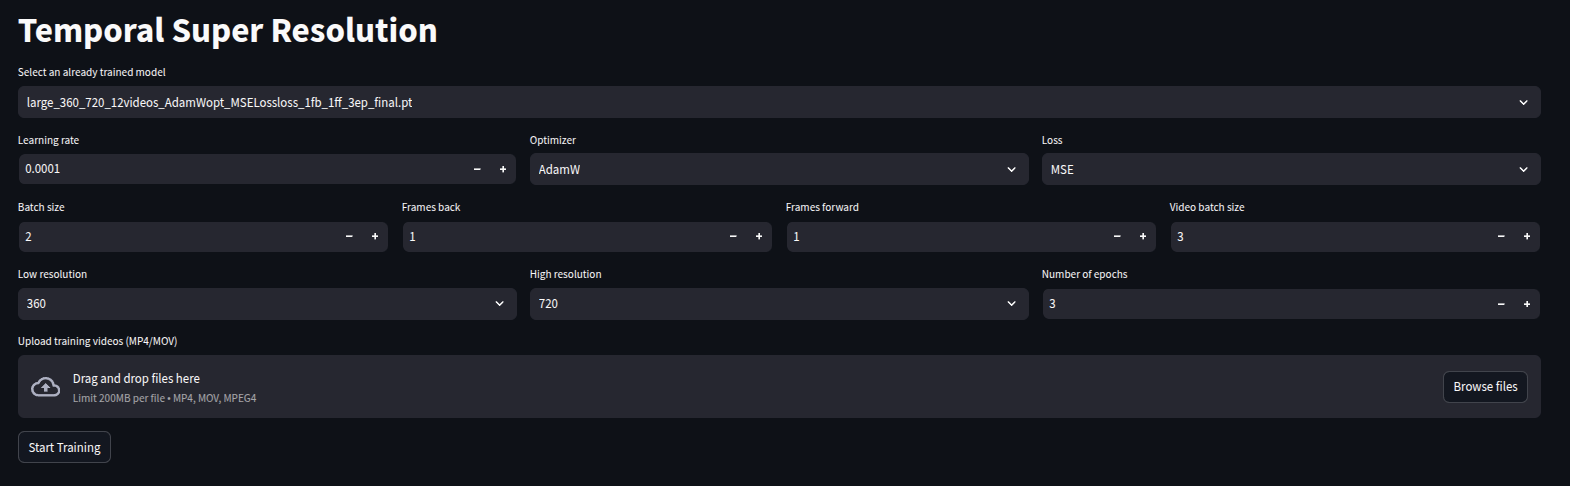

In [6]:
from IPython.display import Image
Image('resources/train.png')

GUI allows to choose all the necessary hyperparameters, if you have an already trained model in models/ directory you can choose it to "uptrain" it, otherwise you can train a new model from scratch. This page expects that the videos you provide will be at least the size of High resolution parameter, and they need to have 16:9 proportions


After you click start training progress bars and graphs will appear allowing you to monitor the training process. Program generates 3x3 graph grid, where first row concerns the subsequent batches of training, the second batches of validation, and the third epochs. The first column shows the value of PSNR metric, the second column shows the value of SSIM metric, and the third column shows the value of currently chosen loss function. The graphs are updated after each batch and epoch. Epochs loss and metrics are also logged to the mlflow and can be retrieved later. MLflow saves also the model after each epoch as well as parameters used in training.


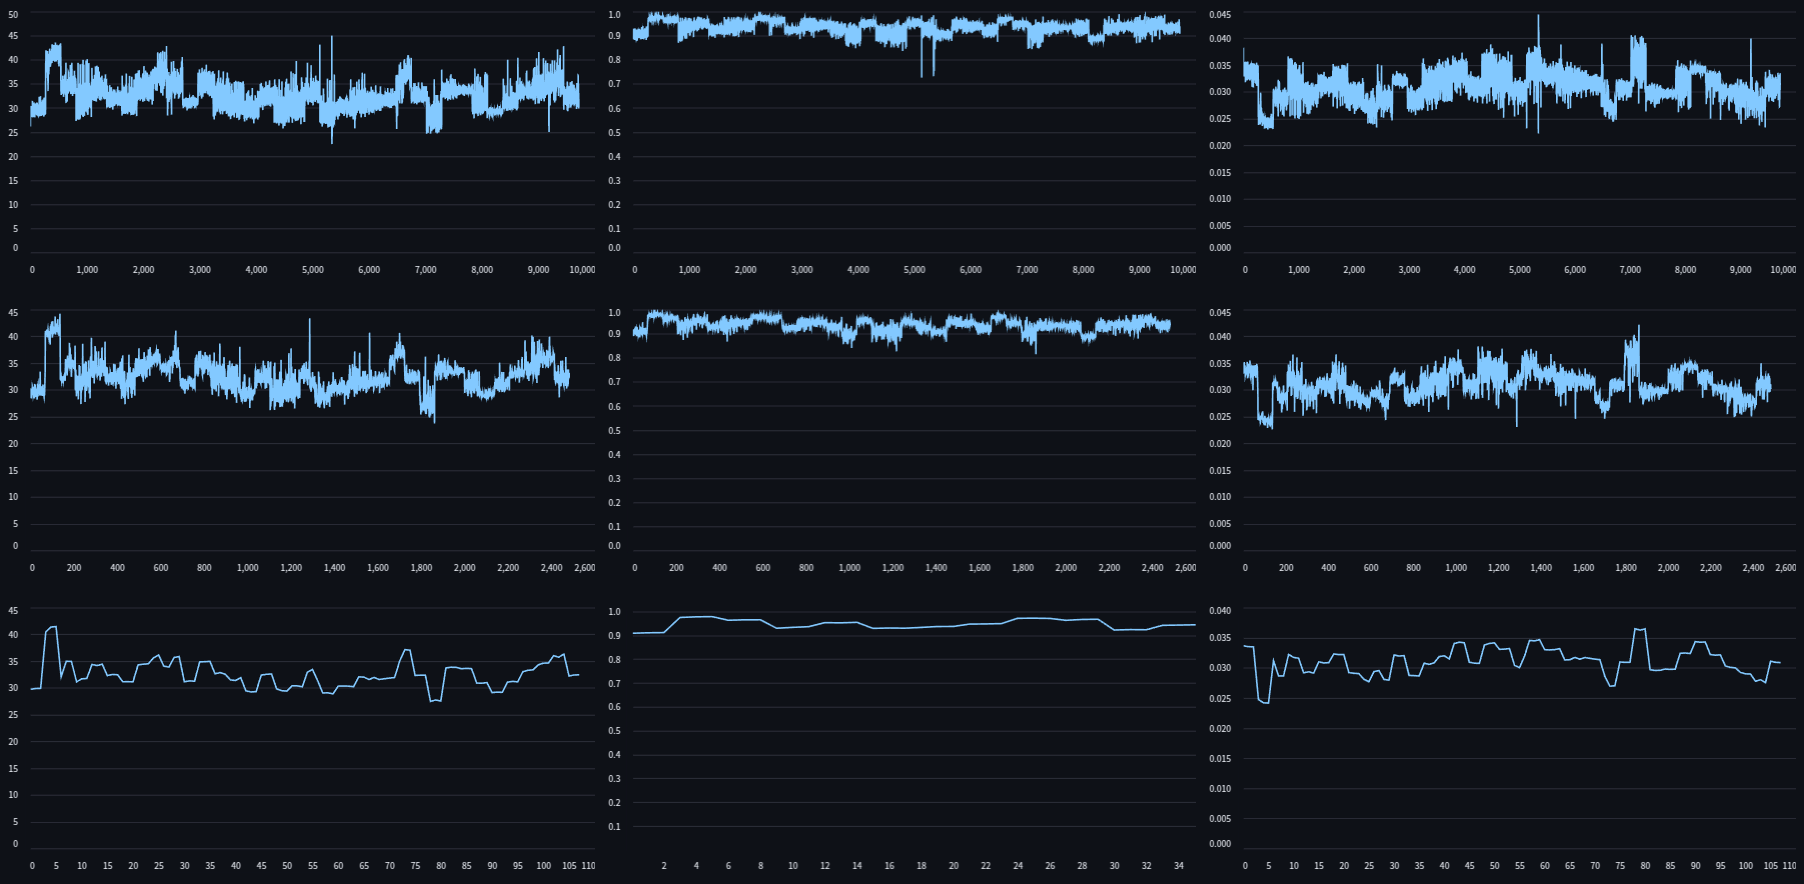

In [7]:
Image('resources/Adam_PSNR_252_10.png')

## Evaluation

Before we go to the evaluation procedure let's describe metrics and loss functions we used:


**PSNR (Peak Signal-to-Noise Ratio):**

$$
\text{PSNR} = 10 \cdot \log_{10}\left(\frac{\text{MAX}^2}{\text{MSE}}\right)
$$

Where:

- $\text{MAX}$ is the maximum possible pixel value of the image.
- $\text{MSE}$ is the Mean Squared Error between images


**SSIM (Structural Similarity Index):**
$$\text{SSIM}(x, y) = \frac{(2\mu*x\mu_y + C_1)(2\sigma*{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)} $$

Where:

- $\mu_x, \mu_y$ are the mean intensities of $x$ and $y$.
- $\sigma_x^2, \sigma_y^2$ are the variances of $x$ and $y$.
- $\sigma\_{xy}$ is the covariance between $x$ and $y$.
- $C_1 = (k_1 L)^2$ and $C_2 = (k_2 L)^2$ are constants to stabilize the division (typically $k_1 = 0.01$, $k_2 = 0.03$, and $L$ is the dynamic range of pixel values).


Based on these two metrics we introduce two loss functions:

- PNSR (Peak Noise-to-Signal Ratio): $\frac{1}{\text{PSNR}}$
- DSSIM (Structural Dissimilarity Index): $1 - \text{SSIM}$


Evaluation works similarly to the training procedure with only difference being that only a single video is being loaded and after the model upscales each frame it is being written to the new high resolution video
Evaluation can be run with in test mode which expect high resolution video input and will report values of metrics just during training, or in inference mode which expects low resolution video input and will generate upscaled video


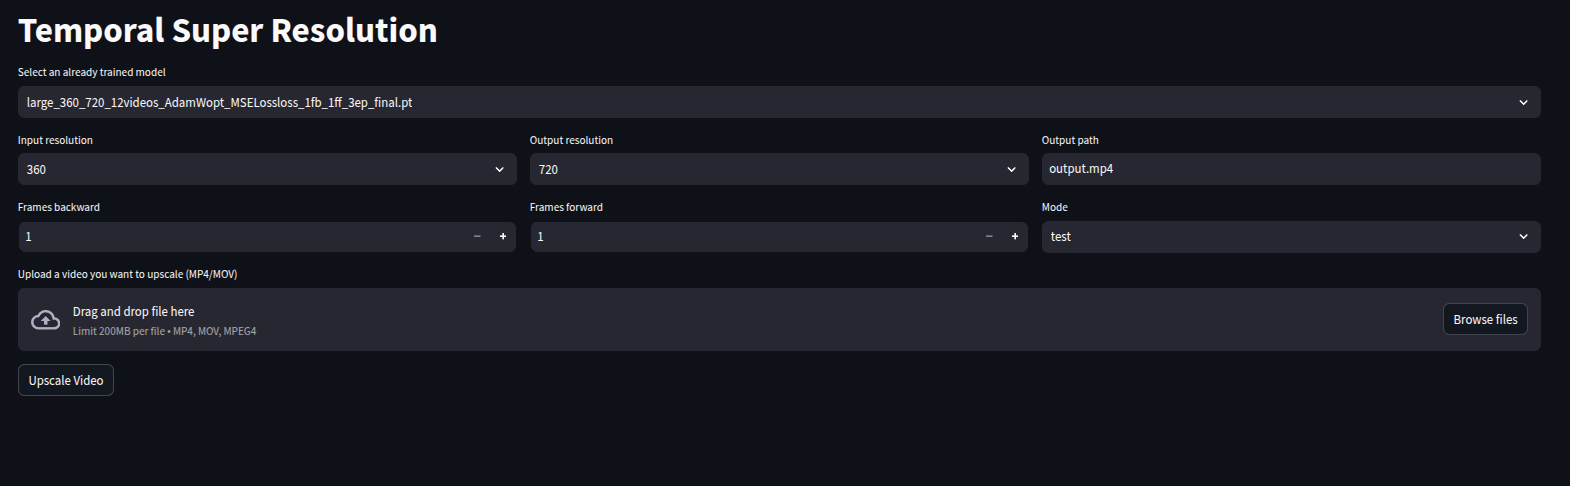

In [8]:
Image('resources/test.png')

Evaluation code for reference:

```python
class Upscaler:
    def __init__(self, model_path, device='auto', original_size=(1920, 1080), target_size=(1280, 720), listener=None, frames_backward=2, frames_forward=2, mode: Literal['test', 'inference'] = 'test'):
        if device == 'auto':
            device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.device = device
        self.original_size = original_size
        self.target_size = target_size
        upscale_factor = original_size[0] / target_size[0]
        self.size = model_path.split('_')[0].split('/')[1]
        if self.size == 'large':
            self.model = TSRCNN_large.load(model_path, frames_backward=frames_backward, frames_forward=frames_forward, upscale_factor=upscale_factor).to(device)
        else:
            self.model = TSRCNN_small.load(model_path, frames_backward=frames_backward, frames_forward=frames_forward, upscale_factor=upscale_factor).to(device)
        self.dataset_format = MultiVideoDataset
        self.listener: SimpleListener = listener
        self.run_name = f"{target_size[1]}p -> {original_size[1]}p {frames_backward}fb{frames_forward}ff TSR {mode}"
        self.history = {'test_metrics': {'PSNR': [], 'SSIM': []}, 'cubic_metrics': {'PSNR': [], 'SSIM': []}}
        self.mode = mode
        self.frames_backward = frames_backward
        self.frames_forward = frames_forward

    def _log_params(self, parameters: Dict):
        for key, value in parameters.items():
            mlflow.log_param(key, value)

    def upscale(self, video_file, fps=60.0, video_path_out="output.mp4"):
        writer = ffmpegcv.VideoWriterNV(file=video_path_out, codec='h264_nvenc', fps=fps, preset='p7', pix_fmt='rgb24') if self.device == 'cuda' else ffmpegcv.VideoWriter(
            file=video_path_out, codec='h264', fps=60.0, preset='p7', pix_fmt='rgb24')
        cubic = ffmpegcv.VideoWriterNV(file="bicubic.mp4", codec='h264_nvenc', fps=fps, preset='p7', pix_fmt='rgb24') if self.device == 'cuda' else ffmpegcv.VideoWriter(
            file="bicubic.mp4", codec='h264', fps=60.0, preset='p7', pix_fmt='rgb24')
        test_dataset = self.dataset_format(video_paths=[video_file], original_size=self.original_size,
                                           target_size=self.target_size, frames_backward=self.frames_backward, frames_forward=self.frames_forward, mode='inference' if self.mode == 'inference' else 'training')
        num_frames = len(test_dataset)
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
        mlflow.set_experiment("temporal_super_resolution_experiment")
        with mlflow.start_run(run_name=self.run_name):
            self._log_params({"video_file": video_file,
                              "test_size": num_frames,
                              "original_size": self.original_size,
                              "target_size": self.target_size})
        self.model.eval()
        test_psnrs = []
        test_ssim = []
        cubic_psnrs = []
        cubic_ssim = []
        test_pbar = tqdm(test_loader, total=num_frames, unit='frame')
        if self.mode == 'test':
            for i, ((prev_frames, low_res_frame, next_frames), high_res_frame) in enumerate(test_pbar):
                pred_frame, metrics = self.test_batch(prev_frames, low_res_frame, next_frames, high_res_frame)
                test_psnrs.append(metrics[0])
                test_ssim.append(metrics[1])
                test_pbar.set_postfix({'test_psnr': metrics[0], 'test_ssim': metrics[1]})
                self.history['test_metrics']['PSNR'].append(metrics[0])
                self.history['test_metrics']['SSIM'].append(metrics[1])
                if self.listener is not None:
                    self.listener.test_batch_callback((i+1)/len(test_loader), self.history)
                cubic_frame = nn.functional.interpolate(low_res_frame, self.original_size[::-1], mode='bicubic')
                cubic_metrics = (PSNR(cubic_frame, high_res_frame).item(), SSIM(cubic_frame, high_res_frame).item())
                cubic_psnrs.append(cubic_metrics[0])
                cubic_ssim.append(cubic_metrics[1])
                self.history['cubic_metrics']['PSNR'].append(cubic_metrics[0])
                self.history['cubic_metrics']['SSIM'].append(cubic_metrics[1])
                cubic_frame = (np.clip(cubic_frame.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)*255).astype(np.uint8)
                cubic.write(cubic_frame)
                out = pred_frame.squeeze(0).permute(1, 2, 0).cpu().numpy()
                out = np.clip(out, 0, 1)
                out = (out * 255).astype(np.uint8)
                writer.write(out)
        else:
            for i, (prev_frames, low_res_frame, next_frames) in enumerate(test_pbar):
                if self.listener is not None:
                    self.listener.test_batch_callback((i+1)/len(test_loader), None)
                pred_frame = self.upscale_batch(prev_frames, low_res_frame, next_frames, high_res_frame)
                cubic_frame = nn.functional.interpolate(low_res_frame, self.original_size[::-1], mode='bicubic')
                cubic_frame = (np.clip(cubic_frame.squeeze(0).permute(1, 2, 0).cpu().numpy(), 0, 1)*255).astype(np.uint8)
                cubic.write(cubic_frame)
                test_pbar.set_postfix({'frame': i})
                out = pred_frame.squeeze(0).permute(1, 2, 0).cpu().numpy()
                out = np.clip(out, 0, 1)
                out = (out * 255).astype(np.uint8)
                writer.write(out)
        cv2.destroyAllWindows()
        writer.release()
        cubic.release()
        if self.mode == 'test':
            final_psnr = sum(test_psnrs)/len(test_psnrs)
            final_ssim = sum(test_ssim)/len(test_ssim)
            final_cubic_psnr = sum(cubic_psnrs)/len(cubic_psnrs)
            final_cubic_ssim = sum(cubic_ssim)/len(cubic_ssim)
            if self.listener is not None:
                self.listener.final_loss_callback(final_psnr, final_ssim, final_cubic_psnr, final_cubic_ssim)
            mlflow.log_metric("test_psnr", final_psnr)
            mlflow.log_metric("test_ssim", final_ssim)
            return final_psnr, final_ssim, final_cubic_psnr, final_cubic_ssim

    @torch.no_grad()
    def test_batch(self, prev_frames, low_res_frame, next_frames, high_res_frame):
        prev_frames = prev_frames.to(self.device)
        low_res_frame = low_res_frame.to(self.device)
        next_frames = next_frames.to(self.device)
        high_res_frame = high_res_frame.to(self.device)
        if self.size == 'small':
            high_res_frame = high_res_frame[:, :, 6:-6, 6:-6]
        if self.size == 'large':
            high_res_frame = high_res_frame[:, :, 9:-9, 9:-9]
        pred_high_res_frame = self.model(prev_frames, low_res_frame, next_frames)
        psnr = PSNR(pred_high_res_frame, high_res_frame).item()
        ssim = SSIM(pred_high_res_frame, high_res_frame).item()
        return pred_high_res_frame, (psnr, ssim)

    @torch.no_grad()
    def upscale_batch(self, prev_frames, low_res_frame, next_frames):
        prev_frames = prev_frames.to(self.device)
        low_res_frame = low_res_frame.to(self.device)
        next_frames = next_frames.to(self.device)
        pred_high_res_frame = self.model(prev_frames, low_res_frame, next_frames)
        return pred_high_res_frame
```


### Our Results

We wanted to test 3 optimizers AdamW, Adagrad, and SGD, and 3 loss functions MSE, PNSR, and DSSIM, additionally we wanted to test the larger version of the model, however due to the computational limitations we couldn't train each model on the whole data so we started with a smaller dataset of 36 videos (~10,000 frames) and uptrained only the models which got good results. In this first turn on 36 datasets and 10 epochs we trained in total 6 models:

- small model with AdamW optimizer and MSE loss
- small model with AdamW optimizer and PNSR loss
- small model with AdamW optimizer and DSSIM loss
- large model with AdamW optimizer and MSE loss
- small model with Adagrad optimizer and MSE loss
- small model with Adagrad optimizer and PNSR loss
- small model with SGD optimizer and MSE loss

**Hyper paramters**\
For each model we used 0.0001 learning rate as it is a popular choice and a single past and future frame. We tried using 2 frames but the results were not good enough to justify the increased computational demand. Each model was trained ans tested on 360->730p upscaling, because smaller image size allowed us to train the models faster. Batch size was set to 8 which was dictated by the VRAM capacity of the GPU.

**Training and inference times**\
Training of a single model in this configuration took around 2.5h this was also true for larger model trained with smaller number of epochs, and later when we training models on 108 videos with 3 epochs the time was also similar. Inference with smaller model takes around 50s per video, 6 frames per second, and with larger model around 75s per video, 4 frames per second.

Already in the training phase model trained with SGD optimizer gave results so poor that we resigned from training it on the two remaining losses. Adagrad's performance was similarly poor and we skipped training it on DSSIM loss. As mentioned before the large model was trained only for 3 epochs instead of 10 due to computational limitations which resulted in underfitting. After training we evaluated the models on 10 videos from the dataset (none of which were used in training) for each of them we calculate average values of metrics all frames, Since cubic interpolation is our baseline we also calculated the same metrics for it calculated the difference between the model metrics and cubic metrics. Additionally since having two separate metrics made it difficult to compare models we introduced an additional metric QM (Quality Measure) defined as: a geometric mean of PSNR and DSSIM.
$$\text{Quality Measure (QM)} = \sqrt{\text{PNSR}*\text{DSSIM}}$$
To compare models we also averaged the results over all 10 testing videos and calulated a score as number of videos in which given model outperformed the cubic interpolation. The results are presented in the table below:


In [9]:
import pandas as pd
pd.read_csv('resources/results1.csv')

,model,100.mp4_psnr,100.mp4_qm,100.mp4_ssim,1000.mp4_psnr,1000.mp4_qm,1000.mp4_ssim,200.mp4_psnr,200.mp4_qm,200.mp4_ssim,...,800.mp4_psnr,800.mp4_qm,800.mp4_ssim,900.mp4_psnr,900.mp4_qm,900.mp4_ssim,average_psnr,average_ssim,average_qm,score
0,large_360_720_36videos_AdamWopt_MSELossloss_1f...,-3.734211,-0.300641,-0.006046,-0.452009,-0.297245,-0.089115,0.450476,0.048059,0.002965,...,-0.115380,-0.022719,-0.004397,0.430492,0.071991,0.012013,-0.963966,-0.026104,-0.154099,0.5
1,small_360_720_36videos_Adagradopt_MSELossloss_...,-6.165242,-0.527323,-0.017874,-4.967614,-0.918187,-0.169263,-4.230602,-0.824915,-0.159152,...,-2.170785,-0.433223,-0.084580,-2.959594,-0.578530,-0.111705,-4.707401,-0.111740,-0.721222,0.0
2,small_360_720_36videos_Adagradopt_PNSRloss_1fb...,-5.767887,-0.491491,-0.016400,-4.046040,-0.665161,-0.108710,-3.625270,-0.693373,-0.131711,...,-1.761099,-0.347364,-0.067251,-2.554079,-0.485140,-0.091525,-3.921213,-0.082794,-0.569042,0.0
3,small_360_720_36videos_AdamWopt_DSSIMloss_1fb_...,-4.487203,-0.339390,-0.000088,0.177847,-0.037914,-0.018717,0.310632,0.070956,0.015380,...,0.103374,0.041477,0.011194,0.412186,0.097714,0.021601,-0.949440,-0.002913,-0.082781,0.6
4,small_360_720_36videos_AdamWopt_MSELossloss_1f...,-6.452513,-0.500426,-0.002212,0.173088,-0.048839,-0.022369,0.308065,0.034897,0.002735,...,0.070231,0.007311,0.000445,0.294060,0.054356,0.010020,-1.333145,-0.007172,-0.125245,0.4
5,small_360_720_36videos_AdamWopt_PNSRloss_1fb_1...,-1.699418,-0.134431,-0.002420,-0.463035,-0.281817,-0.083579,0.523455,0.058180,0.004271,...,0.133572,0.008140,-0.001122,0.514038,0.077649,0.011440,-0.700565,-0.029648,-0.145092,0.6
6,small_360_720_36videos_SGDopt_MSELossloss_1fb_...,-18.034602,-1.647082,-0.056695,-9.682540,-1.876009,-0.359083,-9.181472,-1.794721,-0.345958,...,-6.394648,-1.161814,-0.210196,-8.182921,-1.561708,-0.295159,-11.706562,-0.240023,-1.704240,0.0


Unfortunately in this first stage none of the trained models outperformed the interpolation on average, however AdamW models trained on DSSIM and PNSR outperformed the cubic interpolation on 6 out of 10 videos so we selected them for the next stage


In the next stage we uptrained the selected models with 108 more videos and 3 more epochs, the results are presented in the table below:


In [10]:
pd.read_csv('resources/results2.csv')

,model,100.mp4_psnr,100.mp4_qm,100.mp4_ssim,1000.mp4_psnr,1000.mp4_qm,1000.mp4_ssim,200.mp4_psnr,200.mp4_qm,200.mp4_ssim,...,800.mp4_psnr,800.mp4_qm,800.mp4_ssim,900.mp4_psnr,900.mp4_qm,900.mp4_ssim,average_psnr,average_ssim,average_qm,score
0,small_360_720_144videos_AdamWopt_DSSIMloss_1fb...,-7.910640,-0.612011,-0.000482,0.885894,0.105123,0.009631,0.221640,0.073816,0.019194,...,0.071826,0.060105,0.018558,0.352403,0.103225,0.025399,-0.626638,0.011379,-0.012920,0.8
1,small_360_720_144videos_AdamWopt_PNSRloss_1fb_...,0.397138,0.027760,-0.000419,0.752685,0.056118,-0.003395,0.967591,0.136301,0.018012,...,0.529495,0.073506,0.009657,0.798743,0.128736,0.020600,0.855944,0.004731,0.084644,0.9


Below are the plots of the metrics for the DSSIM model in the format I mentioned earlier:


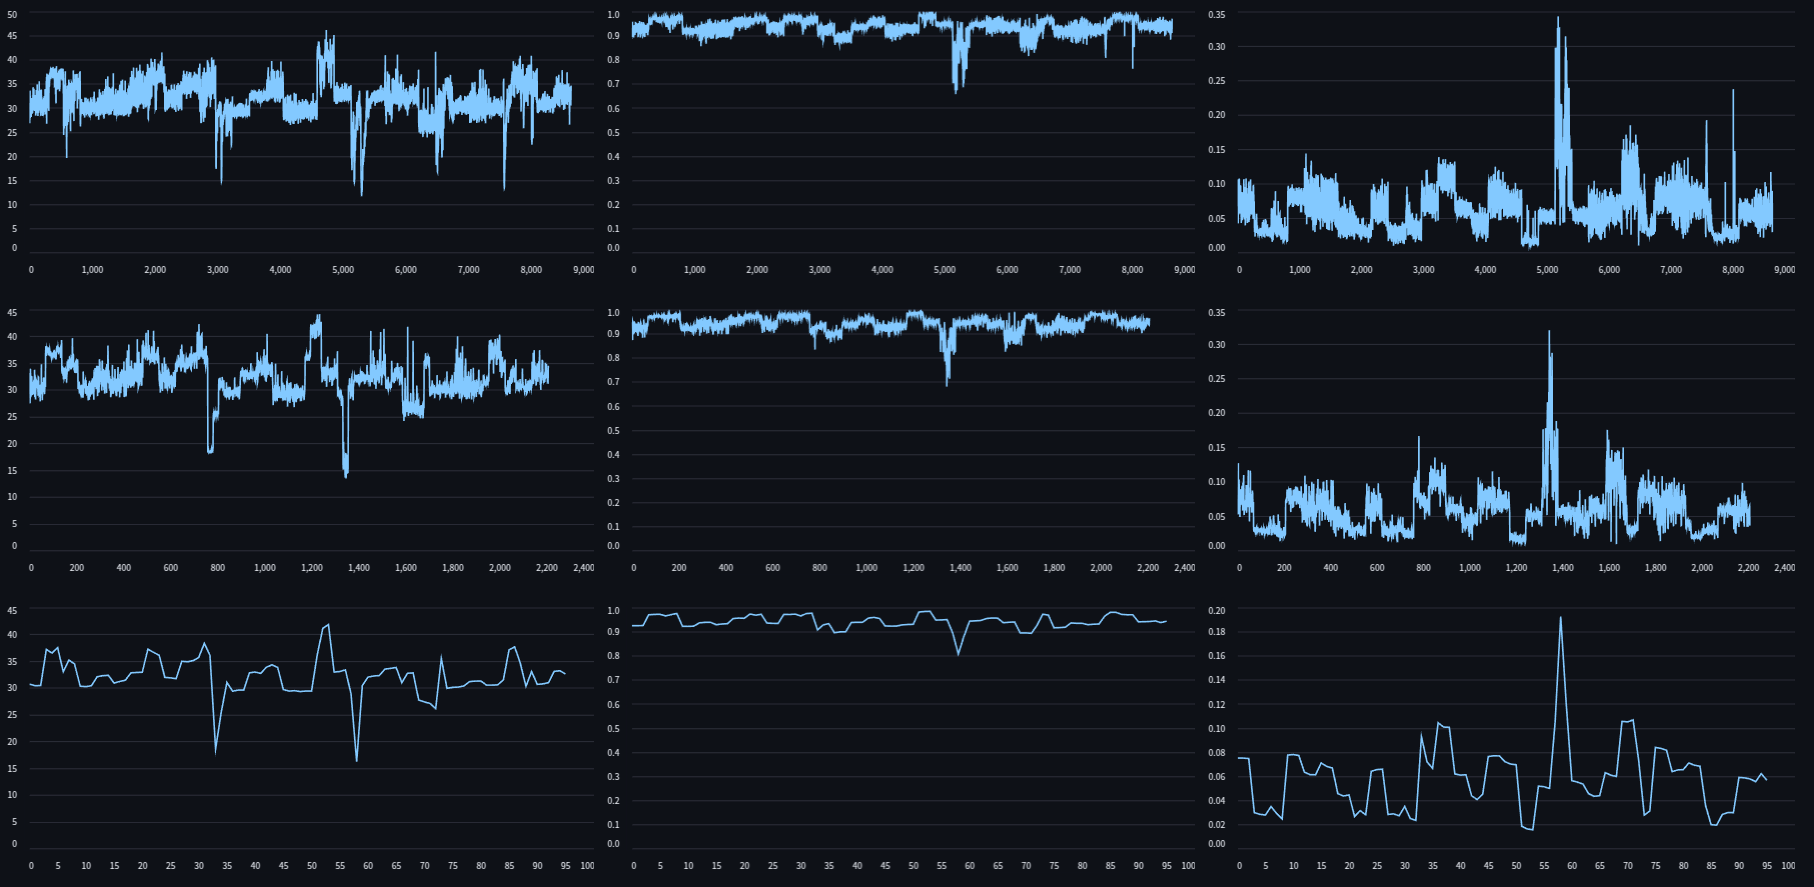

In [12]:
Image('resources/Adam_DSSIM_144_10.png')

And for the PNSR model:


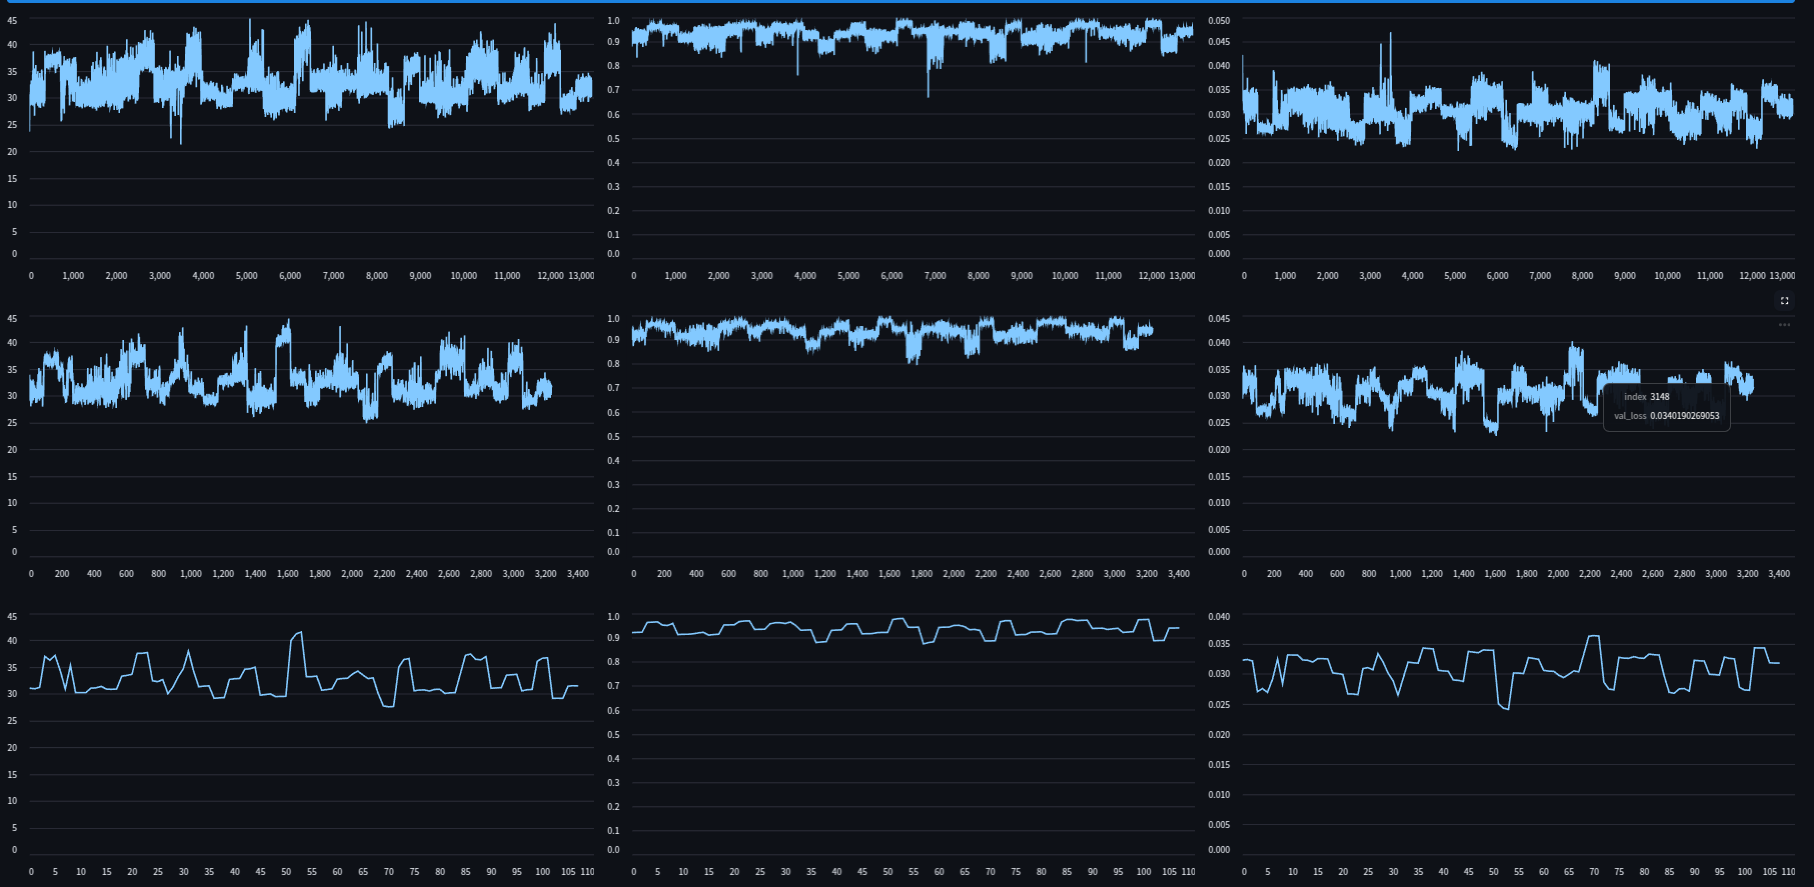

In [13]:
Image('resources/Adam_PNSR_144_10.png')

This time the model trained on the PNSR loss outperformed the cubic interpolation on average and on 9 out of 10 so we decided to give it even more training, once again uptraining with 108 videos and 3 epochs, the results are presented in the table below:


In [11]:
pd.read_csv('resources/results3.csv')

,model,100.mp4_psnr,100.mp4_qm,100.mp4_ssim,1000.mp4_psnr,1000.mp4_qm,1000.mp4_ssim,200.mp4_psnr,200.mp4_qm,200.mp4_ssim,...,800.mp4_psnr,800.mp4_qm,800.mp4_ssim,900.mp4_psnr,900.mp4_qm,900.mp4_ssim,average_psnr,average_ssim,average_qm,score
0,small_360_720_252videos_AdamWopt_PNSRloss_1fb_...,0.511012,0.038215,0.000199,1.020389,0.106209,0.00593,0.931552,0.134291,0.018415,...,0.796978,0.111497,0.014835,0.782417,0.128722,0.021093,0.959765,0.008715,0.105079,1.0


Finally our model came on top on all 10 videos and increased the average QM


Here are the plots for the final training session:


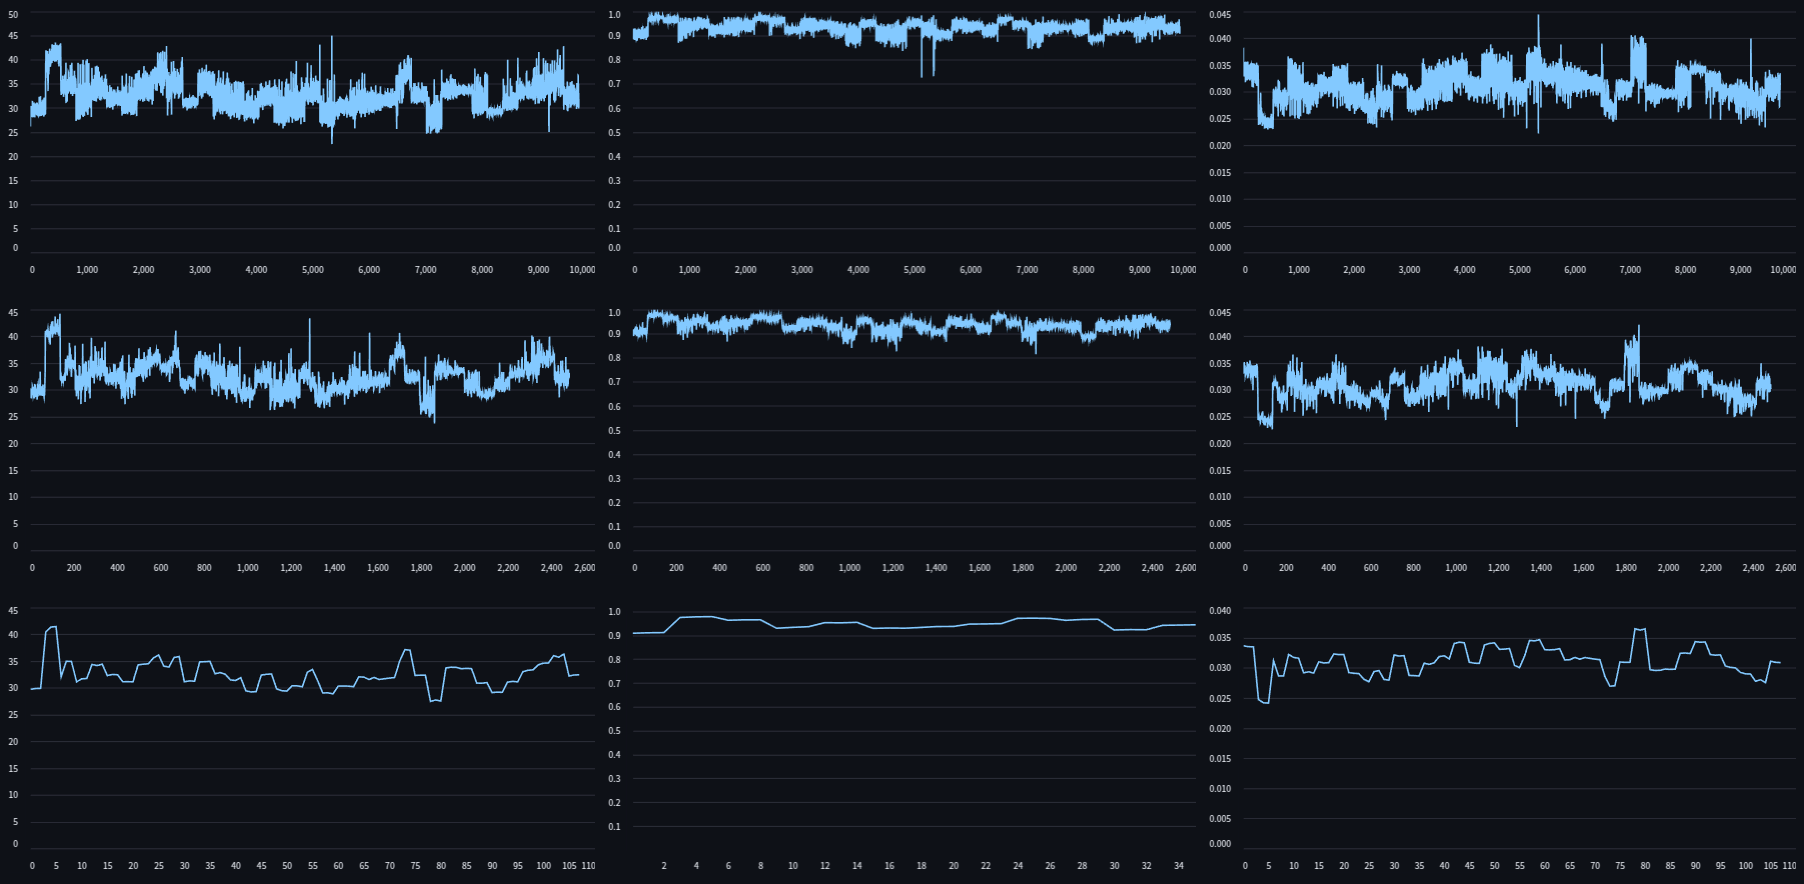

In [14]:
Image('resources/Adam_PSNR_252_10.png')

### Runtime Environment

- Ubuntu 24.04.1, Linux 6.8.0
- Intel Core i5-13500
- 32GB RAM
- NVIDIA GeForce RTX 3060
- NVIDIA Driver 535.183.01
- CUDA 12.0


### References

- Dong, C., Loy, C.C., He, K. and Tang, X., 2015. Image super-resolution using deep convolutional networks. IEEE transactions on pattern analysis and machine intelligence, 38(2), pp.295-307.
- Kappeler, A., Yoo, S., Dai, Q. and Katsaggelos, A.K., 2016. Video super-resolution with convolutional neural networks. IEEE transactions on computational imaging, 2(2), pp.109-122.
- https://medium.com/coinmonks/review-srcnn-super-resolution-3cb3a4f67a7c
- https://www.v7labs.com/blog/image-super-resolution-guide
- https://alexandrosstergiou.github.io/datasets/Inter4K/index.html (Dataset)


### Points

| Item                                         | Points |
| -------------------------------------------- | ------ |
| Super-Resolution                             | 3      |
| Own Architecture                             | 2      |
| Non-trivial solution (using mutliple frames) | 1      |
| At least 10,000 images                       | 1      |
| Our own dataset                              | 1      |
| Testing 3 optimizers                         | 1      |
| Testing 3 loss functions                     | 1      |
| MlFLow                                       | 1      |
| Streamlit GUI                                | 1      |
| DVC                                          | 2      |
| Total                                        | 14     |


### [Github Repository](https://github.com/Dawid64/super-enhanced-resolution)
